In [1]:
%matplotlib inline

from __future__ import absolute_import, division, print_function
# from google3.bigtable.contrib.python import bigtable
# from google3.pyglib import gfile
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import time
import sys
sys.path.append("..")

from bandits.l2r_algs import *
from bandits.l2r_simulator import *

plt.style.use("default")
mpl.rcParams["figure.figsize"] = [4, 3]

mpl.rcParams["axes.linewidth"] = 0.75
mpl.rcParams["grid.linewidth"] = 0.75
mpl.rcParams["lines.linewidth"] = 0.75
mpl.rcParams["patch.linewidth"] = 0.75
mpl.rcParams["xtick.major.size"] = 3
mpl.rcParams["ytick.major.size"] = 3

mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
mpl.rcParams["font.size"] = 7
mpl.rcParams["axes.titlesize"] = "medium"
mpl.rcParams["legend.fontsize"] = "medium"

Simulation with 5 positions and 10 items
.................... 22.7 seconds
Regret: 107.70 +/- 2.03 (median: 107.00, max: 127.00, min: 88.00)
Simulation with 5 positions and 10 items
.................... 202.8 seconds
Regret: 26.05 +/- 2.59 (median: 23.50, max: 56.00, min: 9.00)
Simulation with 5 positions and 10 items
.................... 8.1 seconds
Regret: 68.30 +/- 2.60 (median: 67.00, max: 91.00, min: 46.00)
Simulation with 5 positions and 10 items
.................... 6.7 seconds
Regret: 46.05 +/- 19.62 (median: 26.00, max: 428.00, min: 17.00)


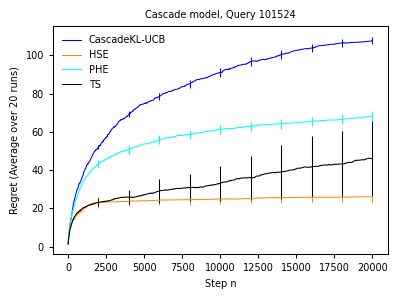

Simulation with 5 positions and 10 items
.................... 23.7 seconds
Regret: 81.40 +/- 4.09 (median: 84.50, max: 108.00, min: 44.00)
Simulation with 5 positions and 10 items
.................... 135.3 seconds
Regret: 55.35 +/- 11.05 (median: 37.50, max: 206.00, min: 15.00)
Simulation with 5 positions and 10 items
.................... 8.5 seconds
Regret: 61.70 +/- 5.02 (median: 62.00, max: 124.00, min: 18.00)
Simulation with 5 positions and 10 items
.................... 6.6 seconds
Regret: 38.30 +/- 5.31 (median: 35.50, max: 107.00, min: 1.00)


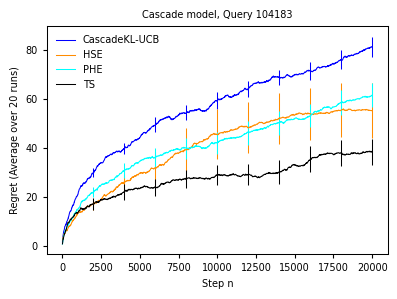

Simulation with 5 positions and 10 items
.................... 23.9 seconds
Regret: 107.70 +/- 3.14 (median: 107.00, max: 134.00, min: 80.00)
Simulation with 5 positions and 10 items
.................... 204.3 seconds
Regret: 36.50 +/- 3.70 (median: 34.00, max: 80.00, min: 18.00)
Simulation with 5 positions and 10 items
.................... 8.2 seconds
Regret: 82.50 +/- 2.49 (median: 81.00, max: 107.00, min: 64.00)
Simulation with 5 positions and 10 items
.................... 6.6 seconds
Regret: 28.80 +/- 1.95 (median: 29.00, max: 52.00, min: 14.00)


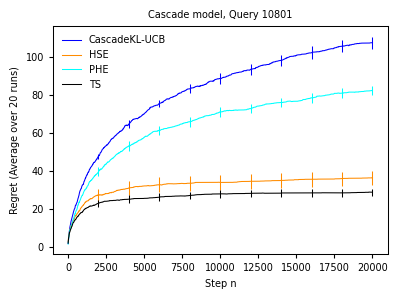

Simulation with 5 positions and 10 items
.................... 19.5 seconds
Regret: 58.40 +/- 3.21 (median: 57.50, max: 89.00, min: 31.00)
Simulation with 5 positions and 10 items
.................... 133.3 seconds
Regret: 38.50 +/- 2.57 (median: 37.50, max: 56.00, min: 18.00)
Simulation with 5 positions and 10 items
.................... 8.5 seconds
Regret: 60.60 +/- 2.43 (median: 62.00, max: 87.00, min: 42.00)
Simulation with 5 positions and 10 items
.................... 6.8 seconds
Regret: 30.40 +/- 2.61 (median: 25.00, max: 56.00, min: 17.00)


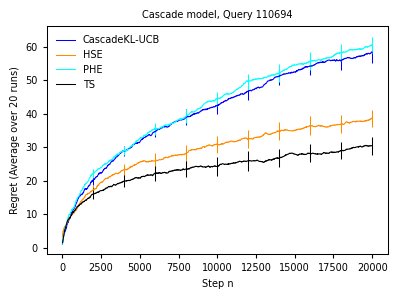

Simulation with 5 positions and 10 items
.................... 22.1 seconds
Regret: 96.30 +/- 4.56 (median: 95.00, max: 146.00, min: 50.00)
Simulation with 5 positions and 10 items
.................... 168.3 seconds
Regret: 59.60 +/- 10.41 (median: 44.00, max: 233.00, min: 21.00)
Simulation with 5 positions and 10 items
.................... 7.7 seconds
Regret: 63.80 +/- 5.78 (median: 61.00, max: 143.00, min: 22.00)
Simulation with 5 positions and 10 items
.................... 6.8 seconds
Regret: 61.85 +/- 8.09 (median: 50.00, max: 125.00, min: 0.00)


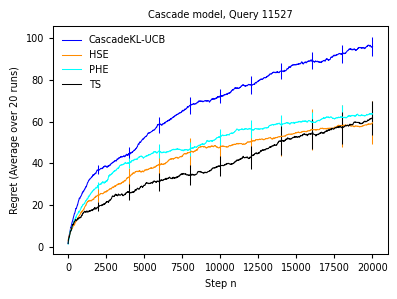

Simulation with 5 positions and 10 items
.................... 22.6 seconds
Regret: 101.40 +/- 4.60 (median: 99.00, max: 138.00, min: 53.00)
Simulation with 5 positions and 10 items
.................... 183.7 seconds
Regret: 36.60 +/- 3.55 (median: 35.50, max: 85.00, min: 9.00)
Simulation with 5 positions and 10 items
.................... 8.0 seconds
Regret: 84.25 +/- 6.57 (median: 88.00, max: 133.00, min: 6.00)
Simulation with 5 positions and 10 items
.................... 7.0 seconds
Regret: 45.85 +/- 7.12 (median: 40.00, max: 108.00, min: -18.00)


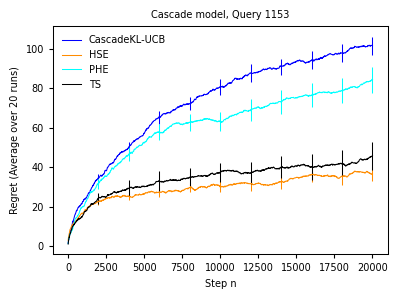

Simulation with 5 positions and 10 items
.................... 24.3 seconds
Regret: 92.50 +/- 5.05 (median: 88.50, max: 132.00, min: 48.00)
Simulation with 5 positions and 10 items
.................... 181.5 seconds
Regret: 49.75 +/- 6.93 (median: 42.50, max: 117.00, min: 2.00)
Simulation with 5 positions and 10 items
.................... 8.3 seconds
Regret: 67.30 +/- 4.03 (median: 68.50, max: 100.00, min: 28.00)
Simulation with 5 positions and 10 items
.................... 6.7 seconds
Regret: 43.70 +/- 6.05 (median: 43.50, max: 104.00, min: -10.00)


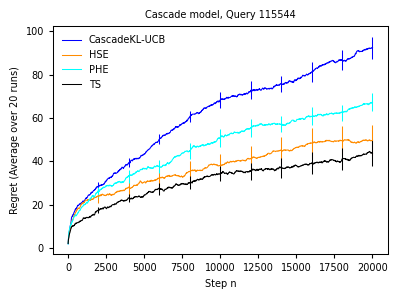

Simulation with 5 positions and 10 items
.................... 19.8 seconds
Regret: 69.95 +/- 1.68 (median: 70.50, max: 82.00, min: 55.00)
Simulation with 5 positions and 10 items
.................... 164.1 seconds
Regret: 51.90 +/- 2.67 (median: 53.00, max: 75.00, min: 29.00)
Simulation with 5 positions and 10 items
.................... 8.1 seconds
Regret: 94.70 +/- 2.76 (median: 96.50, max: 121.00, min: 72.00)
Simulation with 5 positions and 10 items
.................... 6.2 seconds
Regret: 33.15 +/- 2.03 (median: 34.50, max: 48.00, min: 13.00)


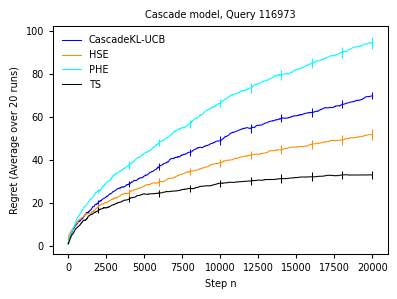

Simulation with 5 positions and 10 items
.................... 21.8 seconds
Regret: 52.90 +/- 2.49 (median: 53.00, max: 75.00, min: 29.00)
Simulation with 5 positions and 10 items
.................... 194.0 seconds
Regret: 47.95 +/- 2.82 (median: 42.50, max: 78.00, min: 30.00)
Simulation with 5 positions and 10 items
.................... 8.1 seconds
Regret: 86.10 +/- 4.05 (median: 85.50, max: 118.00, min: 50.00)
Simulation with 5 positions and 10 items
.................... 6.4 seconds
Regret: 26.80 +/- 1.95 (median: 25.00, max: 44.00, min: 13.00)


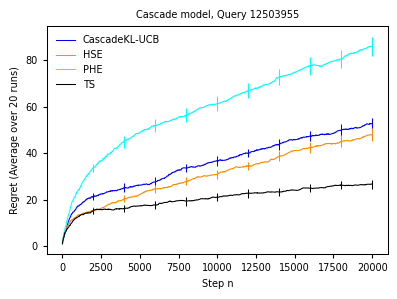

Simulation with 5 positions and 10 items
.................... 22.6 seconds
Regret: 111.00 +/- 2.88 (median: 112.00, max: 140.00, min: 85.00)
Simulation with 5 positions and 10 items
.................... 231.7 seconds
Regret: 55.05 +/- 5.65 (median: 55.50, max: 107.00, min: 16.00)
Simulation with 5 positions and 10 items
.................... 7.9 seconds
Regret: 138.35 +/- 5.39 (median: 134.00, max: 181.00, min: 94.00)
Simulation with 5 positions and 10 items
.................... 6.1 seconds
Regret: 42.85 +/- 5.84 (median: 37.00, max: 150.00, min: 23.00)


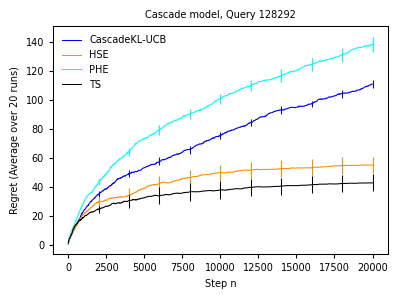

Simulation with 5 positions and 10 items
.................... 22.4 seconds
Regret: 109.50 +/- 3.42 (median: 107.00, max: 145.00, min: 81.00)
Simulation with 5 positions and 10 items
.................... 208.3 seconds
Regret: 51.10 +/- 3.03 (median: 47.00, max: 82.00, min: 29.00)
Simulation with 5 positions and 10 items
.................... 5.1 seconds
Regret: 118.45 +/- 4.63 (median: 120.50, max: 153.00, min: 91.00)
Simulation with 5 positions and 10 items
.................... 4.2 seconds
Regret: 34.85 +/- 1.93 (median: 36.50, max: 51.00, min: 20.00)


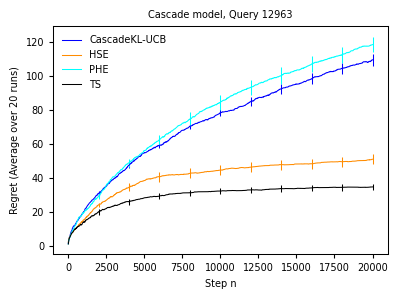

Simulation with 5 positions and 10 items
.................... 15.5 seconds
Regret: 25.40 +/- 1.70 (median: 26.00, max: 39.00, min: 7.00)
Simulation with 5 positions and 10 items
.................... 95.7 seconds
Regret: 24.55 +/- 1.46 (median: 26.50, max: 35.00, min: 10.00)
Simulation with 5 positions and 10 items
.................... 5.8 seconds
Regret: 27.10 +/- 1.33 (median: 24.50, max: 40.00, min: 17.00)
Simulation with 5 positions and 10 items
.................... 5.0 seconds
Regret: 16.95 +/- 2.06 (median: 17.00, max: 31.00, min: -8.00)


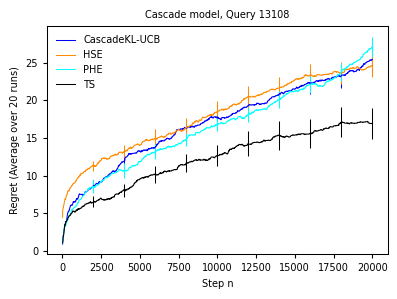

Simulation with 5 positions and 10 items
.................... 20.1 seconds
Regret: 76.95 +/- 2.22 (median: 76.50, max: 93.00, min: 57.00)
Simulation with 5 positions and 10 items
.................... 179.5 seconds
Regret: 44.20 +/- 4.38 (median: 42.00, max: 77.00, min: 17.00)
Simulation with 5 positions and 10 items
.................... 5.1 seconds
Regret: 78.55 +/- 3.52 (median: 78.00, max: 100.00, min: 49.00)
Simulation with 5 positions and 10 items
.................... 4.2 seconds
Regret: 43.20 +/- 6.76 (median: 31.50, max: 129.00, min: 13.00)


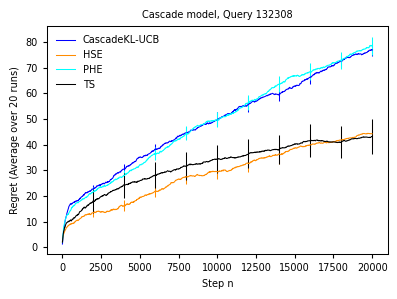

Simulation with 5 positions and 10 items
.................... 18.2 seconds
Regret: 88.30 +/- 2.53 (median: 88.50, max: 108.00, min: 63.00)
Simulation with 5 positions and 10 items
.................... 139.6 seconds
Regret: 30.40 +/- 1.28 (median: 29.00, max: 49.00, min: 22.00)
Simulation with 5 positions and 10 items
.................... 5.2 seconds
Regret: 60.25 +/- 2.67 (median: 57.50, max: 84.00, min: 43.00)
Simulation with 5 positions and 10 items
.................... 4.4 seconds
Regret: 23.90 +/- 1.62 (median: 23.50, max: 43.00, min: 14.00)


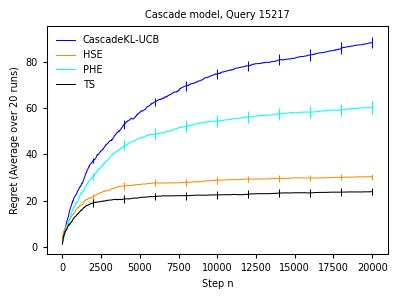

Simulation with 5 positions and 10 items
.................... 19.7 seconds
Regret: 131.55 +/- 4.24 (median: 132.00, max: 161.00, min: 97.00)
Simulation with 5 positions and 10 items
.................... 178.8 seconds
Regret: 36.55 +/- 2.83 (median: 33.50, max: 75.00, min: 16.00)
Simulation with 5 positions and 10 items
.................... 5.1 seconds
Regret: 82.10 +/- 7.78 (median: 77.00, max: 222.00, min: 50.00)
Simulation with 5 positions and 10 items
.................... 4.3 seconds
Regret: 46.55 +/- 7.47 (median: 38.00, max: 168.00, min: 15.00)


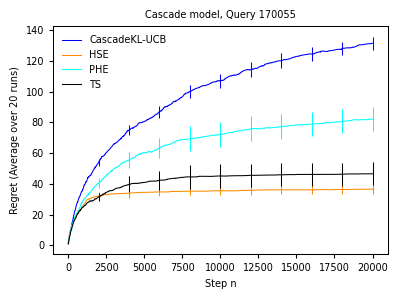

Simulation with 5 positions and 10 items
.................... 20.6 seconds
Regret: 92.35 +/- 3.75 (median: 92.00, max: 137.00, min: 58.00)
Simulation with 5 positions and 10 items
.................... 169.6 seconds
Regret: 35.80 +/- 7.78 (median: 25.00, max: 162.00, min: 17.00)
Simulation with 5 positions and 10 items
.................... 5.6 seconds
Regret: 55.70 +/- 2.46 (median: 52.50, max: 75.00, min: 43.00)
Simulation with 5 positions and 10 items
.................... 5.0 seconds
Regret: 26.30 +/- 1.16 (median: 24.50, max: 36.00, min: 19.00)


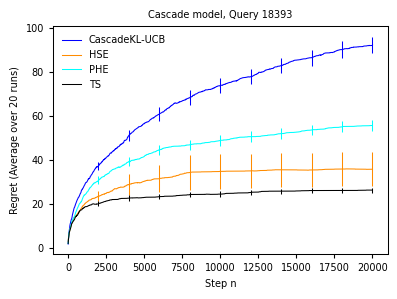

Simulation with 5 positions and 10 items
.................... 20.8 seconds
Regret: 100.35 +/- 3.24 (median: 105.00, max: 124.00, min: 71.00)
Simulation with 5 positions and 10 items
.................... 151.0 seconds
Regret: 33.95 +/- 5.34 (median: 25.50, max: 111.00, min: 13.00)
Simulation with 5 positions and 10 items
.................... 5.5 seconds
Regret: 58.15 +/- 2.77 (median: 53.50, max: 81.00, min: 40.00)
Simulation with 5 positions and 10 items
.................... 4.4 seconds
Regret: 30.60 +/- 3.67 (median: 26.00, max: 90.00, min: 18.00)


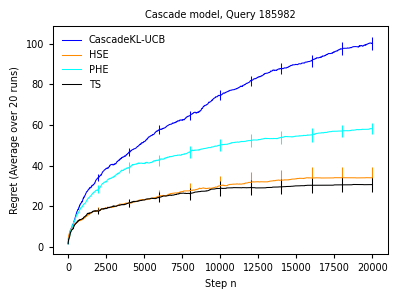

Simulation with 5 positions and 10 items
.................... 19.7 seconds
Regret: 104.90 +/- 3.81 (median: 100.00, max: 140.00, min: 79.00)
Simulation with 5 positions and 10 items
.................... 160.1 seconds
Regret: 40.25 +/- 3.84 (median: 36.00, max: 91.00, min: 16.00)
Simulation with 5 positions and 10 items
.................... 5.3 seconds
Regret: 75.75 +/- 5.06 (median: 67.50, max: 131.00, min: 55.00)
Simulation with 5 positions and 10 items
.................... 4.4 seconds
Regret: 49.75 +/- 6.18 (median: 44.50, max: 125.00, min: 18.00)


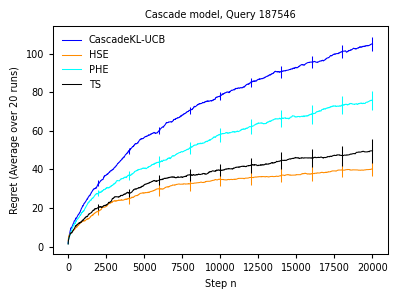

Simulation with 5 positions and 10 items
.................... 17.1 seconds
Regret: 155.80 +/- 5.23 (median: 155.50, max: 187.00, min: 112.00)
Simulation with 5 positions and 10 items
.................... 204.4 seconds
Regret: 93.60 +/- 30.82 (median: 54.00, max: 667.00, min: 20.00)
Simulation with 5 positions and 10 items
.................... 5.2 seconds
Regret: 104.70 +/- 5.17 (median: 100.50, max: 164.00, min: 72.00)
Simulation with 5 positions and 10 items
.................... 4.3 seconds
Regret: 76.10 +/- 20.60 (median: 50.50, max: 446.00, min: 22.00)


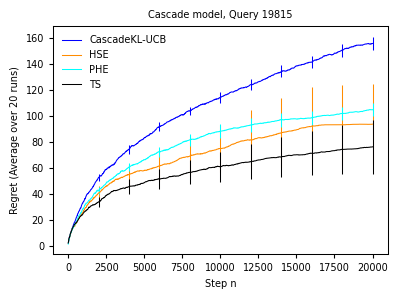

Simulation with 5 positions and 10 items
.................... 17.0 seconds
Regret: 101.65 +/- 2.42 (median: 102.00, max: 126.00, min: 83.00)
Simulation with 5 positions and 10 items
.................... 250.7 seconds
Regret: 48.25 +/- 5.43 (median: 43.00, max: 112.00, min: 26.00)
Simulation with 5 positions and 10 items
.................... 4.9 seconds
Regret: 137.65 +/- 4.33 (median: 138.00, max: 183.00, min: 104.00)
Simulation with 5 positions and 10 items
.................... 4.0 seconds
Regret: 35.40 +/- 2.71 (median: 32.00, max: 59.00, min: 15.00)


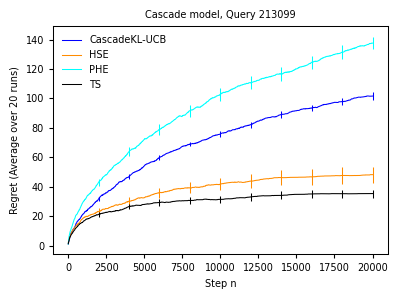

Simulation with 5 positions and 10 items
.................... 20.6 seconds
Regret: 88.50 +/- 7.27 (median: 91.00, max: 157.00, min: 32.00)
Simulation with 5 positions and 10 items
.................... 195.2 seconds
Regret: 68.40 +/- 5.88 (median: 67.50, max: 126.00, min: 17.00)
Simulation with 5 positions and 10 items
.................... 5.3 seconds
Regret: 85.15 +/- 5.26 (median: 88.50, max: 127.00, min: 34.00)
Simulation with 5 positions and 10 items
.................... 4.3 seconds
Regret: 64.90 +/- 8.90 (median: 66.00, max: 170.00, min: 0.00)


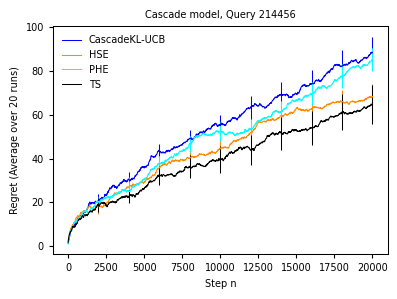

Simulation with 5 positions and 10 items
.................... 21.3 seconds
Regret: 123.95 +/- 6.07 (median: 120.00, max: 183.00, min: 83.00)
Simulation with 5 positions and 10 items
.................... 160.1 seconds
Regret: 82.90 +/- 18.90 (median: 54.50, max: 320.00, min: 9.00)
Simulation with 5 positions and 10 items
.................... 5.5 seconds
Regret: 60.05 +/- 5.01 (median: 57.00, max: 131.00, min: 26.00)
Simulation with 5 positions and 10 items
.................... 4.6 seconds
Regret: 70.45 +/- 11.26 (median: 47.50, max: 186.00, min: 17.00)


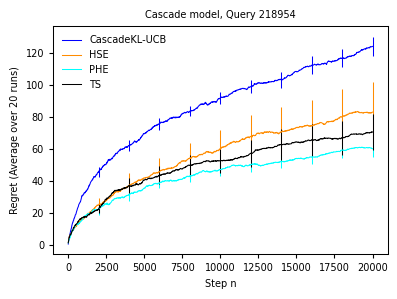

Simulation with 5 positions and 10 items
.................... 21.9 seconds
Regret: 87.90 +/- 2.36 (median: 86.00, max: 112.00, min: 63.00)
Simulation with 5 positions and 10 items
.................... 143.9 seconds
Regret: 30.70 +/- 2.73 (median: 28.50, max: 66.00, min: 17.00)
Simulation with 5 positions and 10 items
.................... 5.6 seconds
Regret: 59.75 +/- 2.44 (median: 60.00, max: 80.00, min: 41.00)
Simulation with 5 positions and 10 items
.................... 4.5 seconds
Regret: 28.70 +/- 1.93 (median: 24.50, max: 48.00, min: 16.00)


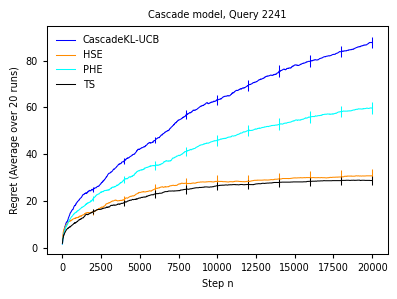

Simulation with 5 positions and 10 items
.................... 19.6 seconds
Regret: 82.15 +/- 3.92 (median: 82.50, max: 120.00, min: 51.00)
Simulation with 5 positions and 10 items
.................... 147.3 seconds
Regret: 36.80 +/- 3.22 (median: 35.00, max: 69.00, min: 9.00)
Simulation with 5 positions and 10 items
.................... 5.3 seconds
Regret: 54.45 +/- 3.59 (median: 53.50, max: 85.00, min: 26.00)
Simulation with 5 positions and 10 items
.................... 4.7 seconds
Regret: 42.35 +/- 3.85 (median: 39.00, max: 82.00, min: 10.00)


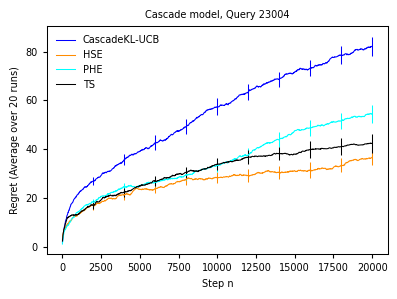

Simulation with 5 positions and 10 items
.................... 17.3 seconds
Regret: 79.10 +/- 4.14 (median: 80.00, max: 108.00, min: 36.00)
Simulation with 5 positions and 10 items
.................... 157.0 seconds
Regret: 43.00 +/- 3.41 (median: 40.00, max: 73.00, min: 20.00)
Simulation with 5 positions and 10 items
.................... 5.8 seconds
Regret: 67.70 +/- 4.10 (median: 66.50, max: 114.00, min: 44.00)
Simulation with 5 positions and 10 items
.................... 4.6 seconds
Regret: 37.35 +/- 6.43 (median: 36.00, max: 96.00, min: -15.00)


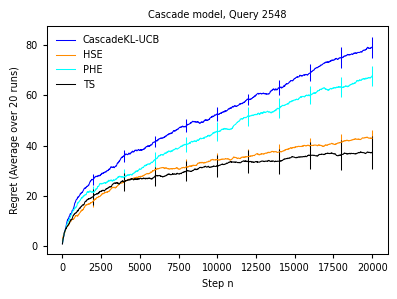

Simulation with 5 positions and 10 items
.................... 25.4 seconds
Regret: 99.30 +/- 2.88 (median: 98.00, max: 118.00, min: 73.00)
Simulation with 5 positions and 10 items
.................... 169.7 seconds
Regret: 51.15 +/- 5.94 (median: 44.00, max: 115.00, min: 25.00)
Simulation with 5 positions and 10 items
.................... 5.5 seconds
Regret: 79.05 +/- 3.15 (median: 78.00, max: 103.00, min: 54.00)
Simulation with 5 positions and 10 items
.................... 4.5 seconds
Regret: 38.85 +/- 4.50 (median: 31.50, max: 101.00, min: 18.00)


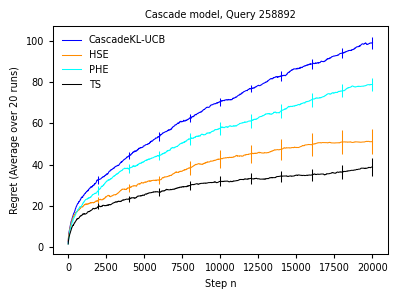

Simulation with 5 positions and 10 items
.................... 19.6 seconds
Regret: 74.40 +/- 5.67 (median: 77.00, max: 120.00, min: 22.00)
Simulation with 5 positions and 10 items
.................... 172.5 seconds
Regret: 42.65 +/- 4.05 (median: 38.50, max: 84.00, min: 14.00)
Simulation with 5 positions and 10 items
.................... 5.6 seconds
Regret: 62.65 +/- 3.79 (median: 63.50, max: 95.00, min: 26.00)
Simulation with 5 positions and 10 items
.................... 4.4 seconds
Regret: 44.95 +/- 4.29 (median: 43.00, max: 97.00, min: 14.00)


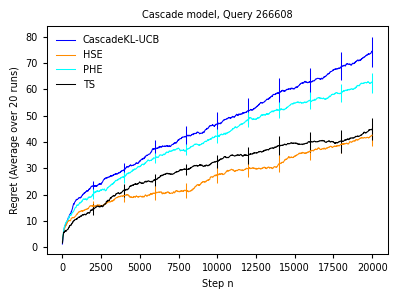

Simulation with 5 positions and 10 items
.................... 15.4 seconds
Regret: 53.25 +/- 3.39 (median: 52.00, max: 80.00, min: 19.00)
Simulation with 5 positions and 10 items
.................... 315.4 seconds
Regret: 31.40 +/- 3.22 (median: 31.00, max: 62.00, min: 7.00)
Simulation with 5 positions and 10 items
.................... 4.6 seconds
Regret: 101.10 +/- 4.00 (median: 97.50, max: 141.00, min: 69.00)
Simulation with 5 positions and 10 items
.................... 3.8 seconds
Regret: 29.50 +/- 2.78 (median: 26.00, max: 58.00, min: 5.00)


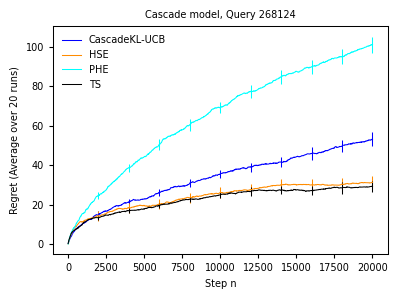

Simulation with 5 positions and 10 items
.................... 19.0 seconds
Regret: 124.05 +/- 3.91 (median: 122.50, max: 171.00, min: 90.00)
Simulation with 5 positions and 10 items
.................... 190.6 seconds
Regret: 53.45 +/- 7.56 (median: 44.50, max: 184.00, min: 25.00)
Simulation with 5 positions and 10 items
.................... 5.3 seconds
Regret: 111.55 +/- 6.55 (median: 104.00, max: 202.00, min: 72.00)
Simulation with 5 positions and 10 items
.................... 4.3 seconds
Regret: 45.90 +/- 5.81 (median: 41.50, max: 133.00, min: 16.00)


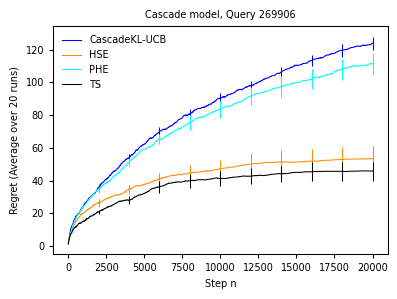

Simulation with 5 positions and 10 items
.................... 19.8 seconds
Regret: 106.80 +/- 5.48 (median: 111.00, max: 143.00, min: 41.00)
Simulation with 5 positions and 10 items
.................... 153.9 seconds
Regret: 40.60 +/- 3.55 (median: 39.50, max: 75.00, min: 20.00)
Simulation with 5 positions and 10 items
.................... 5.3 seconds
Regret: 75.80 +/- 4.16 (median: 70.50, max: 122.00, min: 49.00)
Simulation with 5 positions and 10 items
.................... 4.4 seconds
Regret: 41.65 +/- 5.65 (median: 36.00, max: 136.00, min: 14.00)


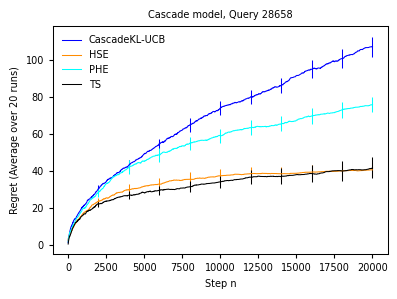

Simulation with 5 positions and 10 items
.................... 17.1 seconds
Regret: 115.65 +/- 4.36 (median: 114.50, max: 164.00, min: 86.00)
Simulation with 5 positions and 10 items
.................... 254.6 seconds
Regret: 52.10 +/- 6.53 (median: 40.50, max: 152.00, min: 24.00)
Simulation with 5 positions and 10 items
.................... 5.1 seconds
Regret: 126.20 +/- 5.28 (median: 121.00, max: 178.00, min: 86.00)
Simulation with 5 positions and 10 items
.................... 4.1 seconds
Regret: 46.75 +/- 4.25 (median: 45.00, max: 91.00, min: 18.00)


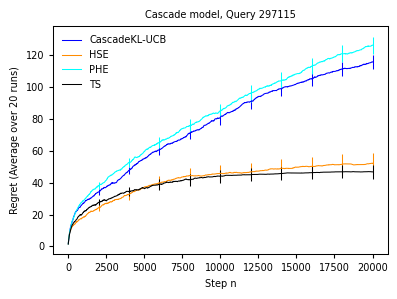

Simulation with 5 positions and 10 items
.................... 19.2 seconds
Regret: 100.40 +/- 2.51 (median: 103.50, max: 119.00, min: 79.00)
Simulation with 5 positions and 10 items
.................... 156.2 seconds
Regret: 45.35 +/- 7.23 (median: 37.00, max: 153.00, min: -2.00)
Simulation with 5 positions and 10 items
.................... 5.2 seconds
Regret: 79.05 +/- 5.88 (median: 73.00, max: 142.00, min: 43.00)
Simulation with 5 positions and 10 items
.................... 4.2 seconds
Regret: 46.20 +/- 5.45 (median: 40.50, max: 121.00, min: 11.00)


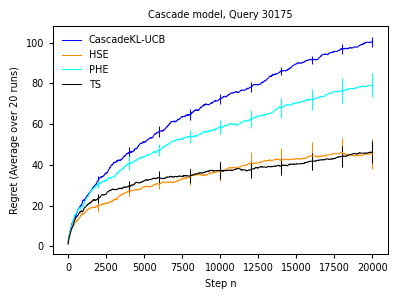

Simulation with 5 positions and 10 items
.................... 18.1 seconds
Regret: 95.40 +/- 3.62 (median: 92.00, max: 123.00, min: 66.00)
Simulation with 5 positions and 10 items
.................... 168.6 seconds
Regret: 39.20 +/- 3.72 (median: 35.00, max: 98.00, min: 16.00)
Simulation with 5 positions and 10 items
.................... 5.2 seconds
Regret: 85.10 +/- 2.61 (median: 83.50, max: 106.00, min: 65.00)
Simulation with 5 positions and 10 items
.................... 4.4 seconds
Regret: 28.45 +/- 1.64 (median: 30.00, max: 39.00, min: 13.00)


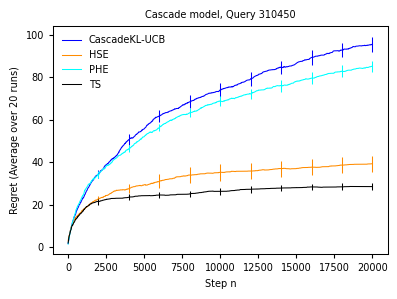

Simulation with 5 positions and 10 items
.................... 18.1 seconds
Regret: 99.05 +/- 3.08 (median: 96.50, max: 135.00, min: 71.00)
Simulation with 5 positions and 10 items
.................... 143.6 seconds
Regret: 50.95 +/- 5.69 (median: 42.00, max: 120.00, min: 23.00)
Simulation with 5 positions and 10 items
.................... 5.3 seconds
Regret: 75.15 +/- 3.38 (median: 72.50, max: 105.00, min: 55.00)
Simulation with 5 positions and 10 items
.................... 4.5 seconds
Regret: 40.40 +/- 6.20 (median: 32.00, max: 147.00, min: 17.00)


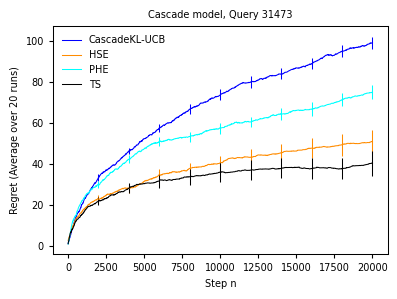

Simulation with 5 positions and 10 items
.................... 19.6 seconds
Regret: 120.35 +/- 3.21 (median: 123.00, max: 148.00, min: 91.00)
Simulation with 5 positions and 10 items
.................... 228.2 seconds
Regret: 34.65 +/- 2.39 (median: 32.50, max: 63.00, min: 22.00)
Simulation with 5 positions and 10 items
.................... 5.3 seconds
Regret: 91.85 +/- 3.14 (median: 90.00, max: 124.00, min: 58.00)
Simulation with 5 positions and 10 items
.................... 4.3 seconds
Regret: 30.85 +/- 1.84 (median: 31.00, max: 48.00, min: 17.00)


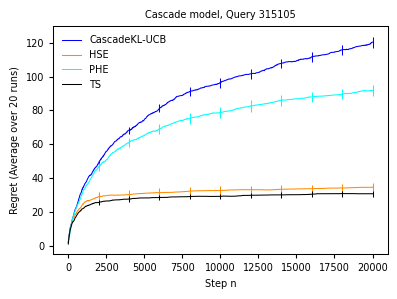

Simulation with 5 positions and 10 items
.................... 18.9 seconds
Regret: 116.30 +/- 6.37 (median: 117.00, max: 179.00, min: 49.00)
Simulation with 5 positions and 10 items
.................... 168.3 seconds
Regret: 38.05 +/- 4.75 (median: 32.50, max: 100.00, min: 16.00)
Simulation with 5 positions and 10 items
.................... 5.2 seconds
Regret: 80.20 +/- 5.89 (median: 73.50, max: 160.00, min: 47.00)
Simulation with 5 positions and 10 items
.................... 4.3 seconds
Regret: 46.70 +/- 6.82 (median: 40.50, max: 118.00, min: 3.00)


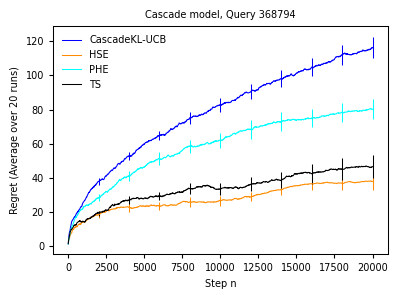

Simulation with 5 positions and 10 items
.................... 16.5 seconds
Regret: 57.85 +/- 3.21 (median: 57.00, max: 85.00, min: 37.00)
Simulation with 5 positions and 10 items
.................... 115.2 seconds
Regret: 41.20 +/- 3.84 (median: 41.50, max: 76.00, min: 7.00)
Simulation with 5 positions and 10 items
.................... 5.3 seconds
Regret: 61.10 +/- 3.46 (median: 57.00, max: 96.00, min: 34.00)
Simulation with 5 positions and 10 items
.................... 4.4 seconds
Regret: 33.25 +/- 2.47 (median: 31.00, max: 69.00, min: 16.00)


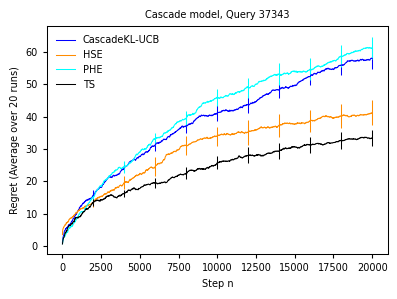

Simulation with 5 positions and 10 items
.................... 19.3 seconds
Regret: 131.45 +/- 3.85 (median: 133.50, max: 166.00, min: 97.00)
Simulation with 5 positions and 10 items
.................... 252.2 seconds
Regret: 46.10 +/- 6.00 (median: 38.50, max: 137.00, min: 9.00)
Simulation with 5 positions and 10 items
.................... 5.2 seconds
Regret: 108.80 +/- 2.92 (median: 109.00, max: 127.00, min: 83.00)
Simulation with 5 positions and 10 items
.................... 4.2 seconds
Regret: 67.05 +/- 13.58 (median: 43.00, max: 264.00, min: 24.00)


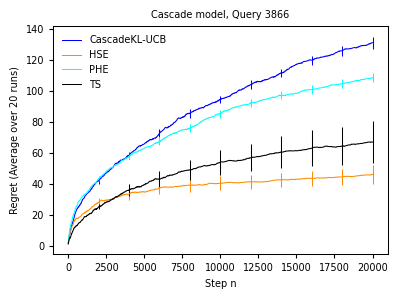

Simulation with 5 positions and 10 items
.................... 20.1 seconds
Regret: 113.20 +/- 8.62 (median: 109.00, max: 190.00, min: 60.00)
Simulation with 5 positions and 10 items
.................... 207.3 seconds
Regret: 69.40 +/- 14.84 (median: 40.00, max: 253.00, min: -33.00)
Simulation with 5 positions and 10 items
.................... 5.1 seconds
Regret: 91.15 +/- 7.94 (median: 84.00, max: 159.00, min: 40.00)
Simulation with 5 positions and 10 items
.................... 4.3 seconds
Regret: 65.30 +/- 7.35 (median: 65.00, max: 144.00, min: -12.00)


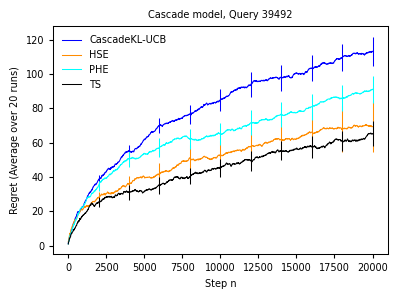

Simulation with 5 positions and 10 items
.................... 17.4 seconds
Regret: 95.00 +/- 4.74 (median: 93.00, max: 131.00, min: 52.00)
Simulation with 5 positions and 10 items
.................... 285.1 seconds
Regret: 50.60 +/- 3.67 (median: 46.00, max: 85.00, min: 26.00)
Simulation with 5 positions and 10 items
.................... 5.1 seconds
Regret: 131.40 +/- 4.95 (median: 130.00, max: 177.00, min: 91.00)
Simulation with 5 positions and 10 items
.................... 4.0 seconds
Regret: 41.15 +/- 3.53 (median: 38.50, max: 77.00, min: 18.00)


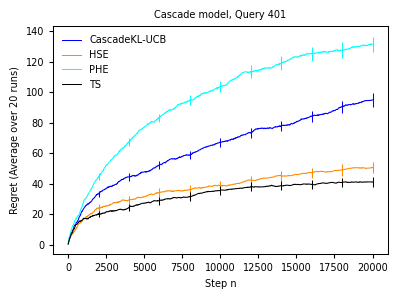

Simulation with 5 positions and 10 items
.................... 18.6 seconds
Regret: 81.15 +/- 2.87 (median: 80.50, max: 108.00, min: 53.00)
Simulation with 5 positions and 10 items
.................... 158.5 seconds
Regret: 50.70 +/- 3.12 (median: 47.00, max: 88.00, min: 30.00)
Simulation with 5 positions and 10 items
.................... 5.3 seconds
Regret: 84.00 +/- 2.42 (median: 87.50, max: 104.00, min: 62.00)
Simulation with 5 positions and 10 items
.................... 4.4 seconds
Regret: 31.55 +/- 3.09 (median: 30.00, max: 69.00, min: 9.00)


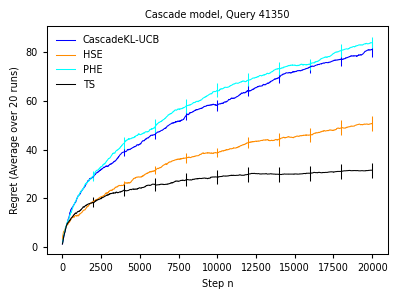

Simulation with 5 positions and 10 items
.................... 17.8 seconds
Regret: 55.55 +/- 4.53 (median: 54.00, max: 103.00, min: 20.00)
Simulation with 5 positions and 10 items
.................... 171.7 seconds
Regret: 52.85 +/- 2.45 (median: 54.50, max: 77.00, min: 31.00)
Simulation with 5 positions and 10 items
.................... 5.3 seconds
Regret: 76.80 +/- 4.14 (median: 74.00, max: 109.00, min: 38.00)
Simulation with 5 positions and 10 items
.................... 4.3 seconds
Regret: 33.85 +/- 5.42 (median: 27.00, max: 111.00, min: 4.00)


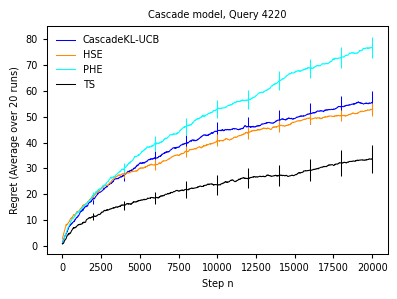

Simulation with 5 positions and 10 items
.................... 18.0 seconds
Regret: 108.70 +/- 3.84 (median: 108.50, max: 135.00, min: 79.00)
Simulation with 5 positions and 10 items
.................... 284.4 seconds
Regret: 34.95 +/- 3.06 (median: 32.50, max: 68.00, min: 13.00)
Simulation with 5 positions and 10 items
.................... 4.9 seconds
Regret: 154.65 +/- 4.51 (median: 155.00, max: 188.00, min: 107.00)
Simulation with 5 positions and 10 items
.................... 4.0 seconds
Regret: 47.30 +/- 4.90 (median: 42.00, max: 119.00, min: 21.00)


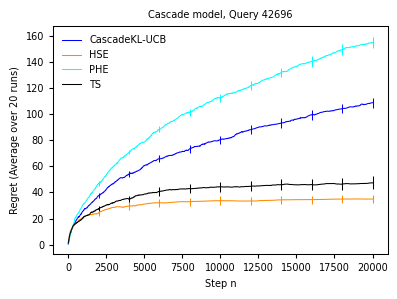

Simulation with 5 positions and 10 items
.................... 18.5 seconds
Regret: 86.45 +/- 4.10 (median: 85.00, max: 122.00, min: 54.00)
Simulation with 5 positions and 10 items
.................... 169.2 seconds
Regret: 49.55 +/- 4.44 (median: 47.00, max: 106.00, min: 22.00)
Simulation with 5 positions and 10 items
.................... 5.7 seconds
Regret: 75.15 +/- 4.07 (median: 71.50, max: 113.00, min: 47.00)
Simulation with 5 positions and 10 items
.................... 4.6 seconds
Regret: 47.85 +/- 6.65 (median: 38.00, max: 121.00, min: 12.00)


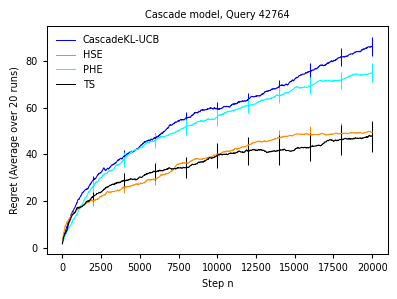

Simulation with 5 positions and 10 items
.................... 20.6 seconds
Regret: 103.65 +/- 3.68 (median: 106.50, max: 140.00, min: 76.00)
Simulation with 5 positions and 10 items
.................... 148.2 seconds
Regret: 54.30 +/- 15.50 (median: 24.50, max: 327.00, min: 12.00)
Simulation with 5 positions and 10 items
.................... 5.4 seconds
Regret: 45.05 +/- 3.17 (median: 42.50, max: 81.00, min: 28.00)
Simulation with 5 positions and 10 items
.................... 4.4 seconds
Regret: 38.30 +/- 9.63 (median: 29.00, max: 221.00, min: 11.00)


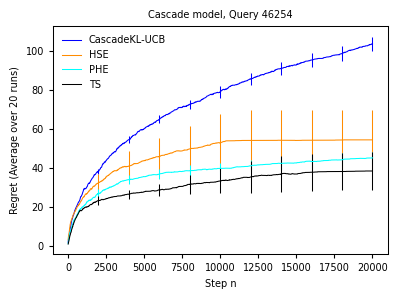

Simulation with 5 positions and 10 items
.................... 18.0 seconds
Regret: 87.85 +/- 3.95 (median: 85.00, max: 130.00, min: 65.00)
Simulation with 5 positions and 10 items
.................... 128.8 seconds
Regret: 35.65 +/- 6.27 (median: 26.00, max: 135.00, min: 14.00)
Simulation with 5 positions and 10 items
.................... 5.2 seconds
Regret: 58.30 +/- 4.76 (median: 53.50, max: 117.00, min: 32.00)
Simulation with 5 positions and 10 items
.................... 4.5 seconds
Regret: 42.40 +/- 7.72 (median: 36.00, max: 182.00, min: 12.00)


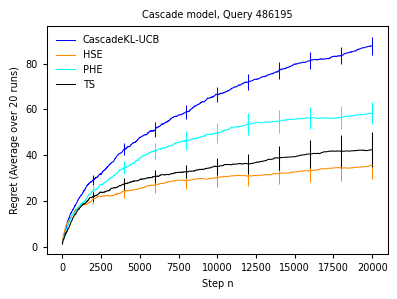

Simulation with 5 positions and 10 items
.................... 19.7 seconds
Regret: 97.80 +/- 6.68 (median: 104.00, max: 150.00, min: 41.00)
Simulation with 5 positions and 10 items
.................... 185.6 seconds
Regret: 44.50 +/- 5.44 (median: 41.00, max: 108.00, min: -10.00)
Simulation with 5 positions and 10 items
.................... 5.3 seconds
Regret: 77.80 +/- 5.93 (median: 73.50, max: 172.00, min: 42.00)
Simulation with 5 positions and 10 items
.................... 4.4 seconds
Regret: 42.45 +/- 4.83 (median: 39.50, max: 93.00, min: 3.00)


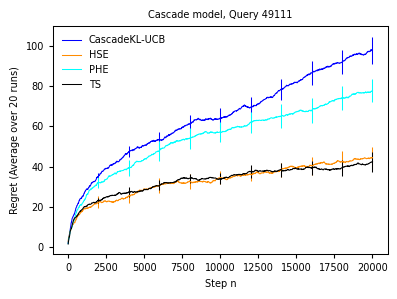

Simulation with 5 positions and 10 items
.................... 16.1 seconds
Regret: 32.25 +/- 2.37 (median: 32.50, max: 52.00, min: 8.00)
Simulation with 5 positions and 10 items
.................... 97.5 seconds
Regret: 26.90 +/- 4.48 (median: 21.00, max: 103.00, min: 7.00)
Simulation with 5 positions and 10 items
.................... 5.4 seconds
Regret: 32.85 +/- 2.59 (median: 32.00, max: 66.00, min: 13.00)
Simulation with 5 positions and 10 items
.................... 4.4 seconds
Regret: 18.05 +/- 1.45 (median: 17.50, max: 35.00, min: 4.00)


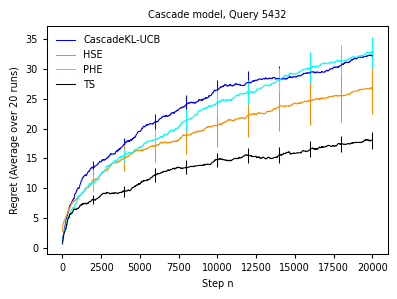

Simulation with 5 positions and 10 items
.................... 19.5 seconds
Regret: 75.90 +/- 3.40 (median: 74.50, max: 102.00, min: 56.00)
Simulation with 5 positions and 10 items
.................... 255.1 seconds
Regret: 55.25 +/- 4.76 (median: 54.00, max: 108.00, min: 25.00)
Simulation with 5 positions and 10 items
.................... 5.3 seconds
Regret: 98.35 +/- 3.78 (median: 98.00, max: 134.00, min: 60.00)
Simulation with 5 positions and 10 items
.................... 4.3 seconds
Regret: 43.35 +/- 4.85 (median: 36.00, max: 108.00, min: 20.00)


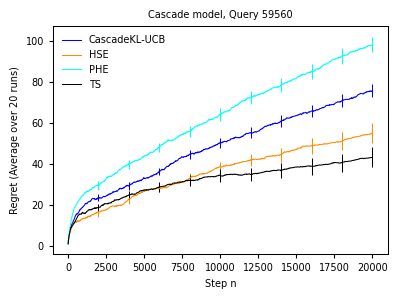

Simulation with 5 positions and 10 items
.................... 19.8 seconds
Regret: 85.25 +/- 3.70 (median: 86.00, max: 119.00, min: 58.00)
Simulation with 5 positions and 10 items
.................... 120.3 seconds
Regret: 43.70 +/- 7.76 (median: 36.50, max: 183.00, min: 11.00)
Simulation with 5 positions and 10 items
.................... 5.7 seconds
Regret: 57.20 +/- 3.54 (median: 56.00, max: 89.00, min: 15.00)
Simulation with 5 positions and 10 items
.................... 4.8 seconds
Regret: 39.45 +/- 4.71 (median: 34.00, max: 87.00, min: 10.00)


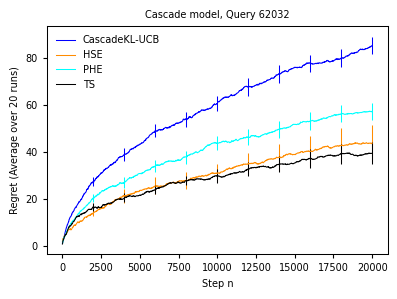

Simulation with 5 positions and 10 items
.................... 21.5 seconds
Regret: 105.65 +/- 3.17 (median: 103.00, max: 134.00, min: 87.00)
Simulation with 5 positions and 10 items
.................... 223.6 seconds
Regret: 25.25 +/- 1.40 (median: 24.50, max: 40.00, min: 16.00)
Simulation with 5 positions and 10 items
.................... 5.3 seconds
Regret: 79.20 +/- 2.48 (median: 77.50, max: 104.00, min: 61.00)
Simulation with 5 positions and 10 items
.................... 4.3 seconds
Regret: 31.40 +/- 2.76 (median: 28.50, max: 69.00, min: 15.00)


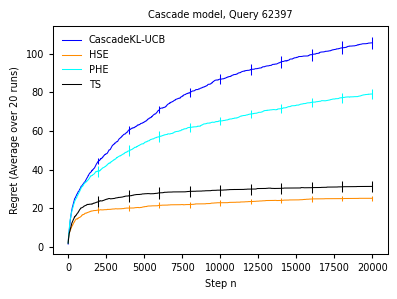

Simulation with 5 positions and 10 items
.................... 20.6 seconds
Regret: 146.50 +/- 5.54 (median: 152.50, max: 179.00, min: 87.00)
Simulation with 5 positions and 10 items
.................... 239.6 seconds
Regret: 100.05 +/- 18.14 (median: 67.00, max: 304.00, min: 19.00)
Simulation with 5 positions and 10 items
.................... 5.3 seconds
Regret: 113.50 +/- 6.52 (median: 109.00, max: 182.00, min: 64.00)
Simulation with 5 positions and 10 items
.................... 4.3 seconds
Regret: 80.45 +/- 21.57 (median: 42.50, max: 411.00, min: 21.00)


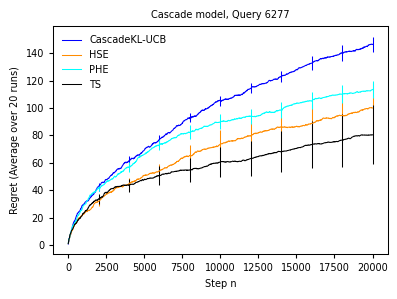

Simulation with 5 positions and 10 items
.................... 19.2 seconds
Regret: 115.30 +/- 3.66 (median: 115.50, max: 145.00, min: 83.00)
Simulation with 5 positions and 10 items
.................... 192.1 seconds
Regret: 30.40 +/- 1.94 (median: 29.00, max: 55.00, min: 17.00)
Simulation with 5 positions and 10 items
.................... 5.3 seconds
Regret: 80.65 +/- 3.84 (median: 86.00, max: 118.00, min: 48.00)
Simulation with 5 positions and 10 items
.................... 4.3 seconds
Regret: 43.70 +/- 6.08 (median: 35.50, max: 140.00, min: 16.00)


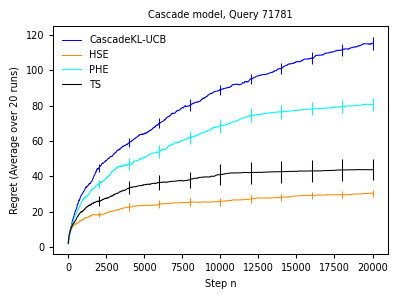

Simulation with 5 positions and 10 items
.................... 20.2 seconds
Regret: 85.25 +/- 3.37 (median: 88.00, max: 115.00, min: 58.00)
Simulation with 5 positions and 10 items
.................... 133.6 seconds
Regret: 34.55 +/- 4.89 (median: 31.50, max: 114.00, min: 15.00)
Simulation with 5 positions and 10 items
.................... 5.3 seconds
Regret: 56.55 +/- 3.15 (median: 54.50, max: 86.00, min: 34.00)
Simulation with 5 positions and 10 items
.................... 4.4 seconds
Regret: 31.35 +/- 4.01 (median: 25.00, max: 80.00, min: 14.00)


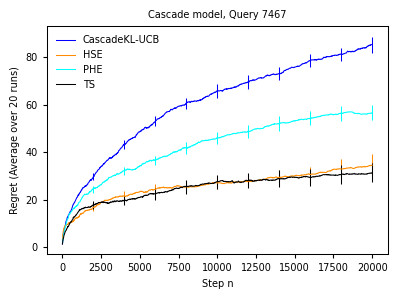

Simulation with 5 positions and 10 items
.................... 18.1 seconds
Regret: 71.05 +/- 4.14 (median: 70.50, max: 108.00, min: 26.00)
Simulation with 5 positions and 10 items
.................... 259.6 seconds
Regret: 39.50 +/- 3.01 (median: 39.00, max: 79.00, min: 21.00)
Simulation with 5 positions and 10 items
.................... 4.9 seconds
Regret: 105.65 +/- 2.93 (median: 106.50, max: 127.00, min: 78.00)
Simulation with 5 positions and 10 items
.................... 3.8 seconds
Regret: 36.90 +/- 2.36 (median: 35.00, max: 58.00, min: 20.00)


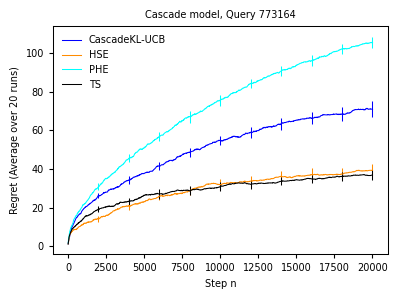

Simulation with 5 positions and 10 items
.................... 17.4 seconds
Regret: 86.50 +/- 3.55 (median: 85.00, max: 133.00, min: 58.00)
Simulation with 5 positions and 10 items
.................... 150.3 seconds
Regret: 40.55 +/- 3.48 (median: 38.50, max: 80.00, min: 20.00)
Simulation with 5 positions and 10 items
.................... 6.0 seconds
Regret: 74.35 +/- 3.49 (median: 71.50, max: 103.00, min: 46.00)
Simulation with 5 positions and 10 items
.................... 5.0 seconds
Regret: 28.70 +/- 1.70 (median: 28.00, max: 43.00, min: 12.00)


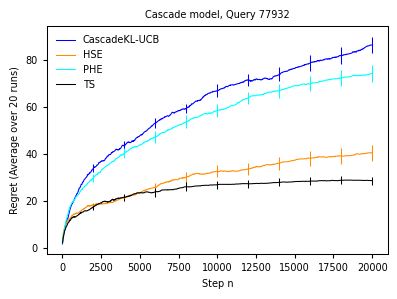

Simulation with 5 positions and 10 items
.................... 20.9 seconds
Regret: 95.05 +/- 3.10 (median: 95.00, max: 119.00, min: 71.00)
Simulation with 5 positions and 10 items
.................... 188.2 seconds
Regret: 39.00 +/- 2.70 (median: 38.50, max: 60.00, min: 17.00)
Simulation with 5 positions and 10 items
.................... 7.1 seconds
Regret: 81.75 +/- 3.22 (median: 83.50, max: 107.00, min: 60.00)
Simulation with 5 positions and 10 items
.................... 4.9 seconds
Regret: 31.90 +/- 2.21 (median: 31.00, max: 55.00, min: 19.00)


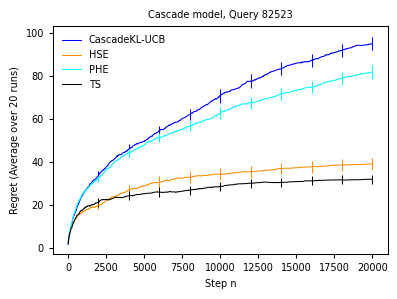

Simulation with 5 positions and 10 items
.................... 20.5 seconds
Regret: 47.20 +/- 1.62 (median: 48.00, max: 64.00, min: 35.00)
Simulation with 5 positions and 10 items
.................... 123.4 seconds
Regret: 33.40 +/- 2.92 (median: 33.50, max: 73.00, min: 16.00)
Simulation with 5 positions and 10 items
.................... 6.7 seconds
Regret: 40.10 +/- 1.98 (median: 41.00, max: 53.00, min: 16.00)
Simulation with 5 positions and 10 items
.................... 5.2 seconds
Regret: 30.00 +/- 4.26 (median: 26.50, max: 107.00, min: 15.00)


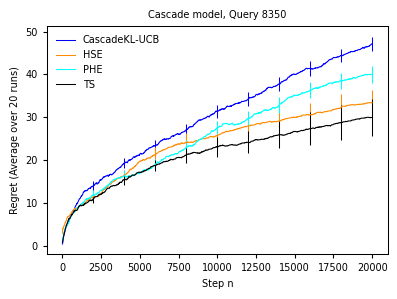

Simulation with 5 positions and 10 items
.................... 19.3 seconds
Regret: 100.15 +/- 6.57 (median: 98.00, max: 164.00, min: 49.00)
Simulation with 5 positions and 10 items
.................... 249.8 seconds
Regret: 52.85 +/- 6.77 (median: 44.50, max: 123.00, min: 7.00)
Simulation with 5 positions and 10 items
.................... 5.5 seconds
Regret: 115.60 +/- 5.86 (median: 114.50, max: 177.00, min: 56.00)
Simulation with 5 positions and 10 items
.................... 4.3 seconds
Regret: 48.85 +/- 7.75 (median: 38.50, max: 162.00, min: 12.00)


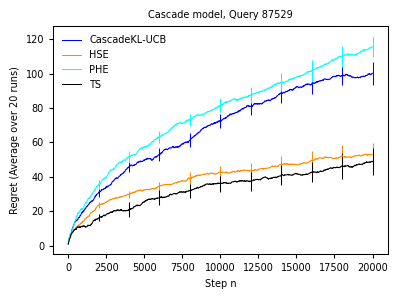

Simulation with 5 positions and 10 items
.................... 21.2 seconds
Regret: 124.95 +/- 5.15 (median: 123.50, max: 167.00, min: 77.00)
Simulation with 5 positions and 10 items
.................... 214.5 seconds
Regret: 72.45 +/- 10.92 (median: 48.50, max: 185.00, min: 13.00)
Simulation with 5 positions and 10 items
.................... 5.8 seconds
Regret: 75.95 +/- 3.46 (median: 71.50, max: 104.00, min: 48.00)
Simulation with 5 positions and 10 items
.................... 4.6 seconds
Regret: 52.50 +/- 8.73 (median: 38.50, max: 167.00, min: 13.00)


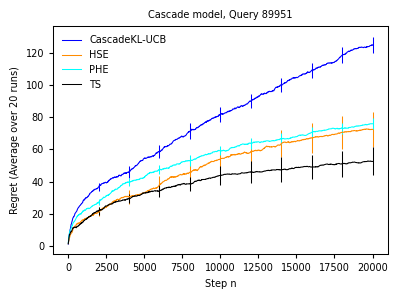

In [3]:
# evaluation on click models
click_model_dir = "./Click Models"
queries = [\
  "101524", "104183", "10801", "110694", "11527", "1153", "115544", "116973", "12503955", "128292", \
  "12963", "13108", "132308", "15217", "170055", "18393", "185982", "187546", "19815", "213099", \
  "214456", "218954", "2241", "23004", "2548", "258892", "266608", "268124", "269906", "28658", \
  "297115", "30175", "310450", "31473", "315105", "368794", "37343", "3866", "39492", "401", \
  "41350", "4220", "42696", "42764", "46254", "486195", "49111", "5432", "59560", "62032", \
  "62397", "6277", "71781", "7467", "773164", "77932", "82523", "8350", "87529", "89951"]

# queries = ["101524", "104183", "10801", "110694", "11527"]
model = "CM"

T = 20000
num_runs = 20
period_size = 10
num_periods = T // period_size

step = np.arange(period_size, T + 1, period_size)
sube = (step.size // 10) * np.arange(1, 11) - 1

for ex in range(len(queries)):
  query = queries[ex]
  env = globals()[model + "Env"]("%s/%s_%s.txt" % (click_model_dir, query, model))

  '''CascadeKLUCB'''
  (regret, bandit) = evaluate_parallel(CascadeKLUCB, env, num_runs, 
                                       T, period_size, num_process=12)
  cumreg = np.cumsum(regret, axis = 0)
  plt.plot(step, np.mean(cumreg, axis = 1), "blue", label = "CascadeKL-UCB")
  plt.errorbar(step[sube], np.mean(cumreg[sube, :], axis = 1), \
    np.std(cumreg[sube, :], axis = 1) / np.sqrt(cumreg.shape[1]), \
    fmt = "none", ecolor = "b")
  
  '''TopRank'''
#   (regret, bandit) = evaluate_parallel(TopRank, env, num_runs, 
#                                         T, period_size, num_process=1)
#   cumreg = np.cumsum(regret, axis = 0)
#   plt.plot(step, np.mean(cumreg, axis = 1), "r", label = "TopRank")
#   plt.errorbar(step[sube], np.mean(cumreg[sube, :], axis = 1), \
#     np.std(cumreg[sube, :], axis = 1) / np.sqrt(cumreg.shape[1]), \
#     fmt = "none", ecolor = "r")

  '''HSE'''
  (regret, bandit) = evaluate_parallel(HS_SWR_scale, env, num_runs, 
                                       T, period_size, num_process=12)
  cumreg = np.cumsum(regret, axis = 0)
  plt.plot(step, np.mean(cumreg, axis = 1), "darkorange", label = "HSE")
  plt.errorbar(step[sube], np.mean(cumreg[sube, :], axis = 1), \
    np.std(cumreg[sube, :], axis = 1) / np.sqrt(cumreg.shape[1]), \
    fmt = "none", ecolor = "darkorange")
    
  '''PHE'''
  (regret, bandit) = evaluate_parallel(PHE, env, num_runs, 
                                       T, period_size, num_process=12)
  cumreg = np.cumsum(regret, axis = 0)
  plt.plot(step, np.mean(cumreg, axis = 1), "cyan", label = "PHE")
  plt.errorbar(step[sube], np.mean(cumreg[sube, :], axis = 1), \
    np.std(cumreg[sube, :], axis = 1) / np.sqrt(cumreg.shape[1]), \
    fmt = "none", ecolor = "cyan")

  '''TS'''
  (regret, bandit) = evaluate_parallel(TS, env, num_runs, 
                                       T, period_size, num_process=12)
  cumreg = np.cumsum(regret, axis = 0)
  plt.plot(step, np.mean(cumreg, axis = 1), "black", label = "TS")
  plt.errorbar(step[sube], np.mean(cumreg[sube, :], axis = 1), \
    np.std(cumreg[sube, :], axis = 1) / np.sqrt(cumreg.shape[1]), \
    fmt = "none", ecolor = "black")

  plt.title("Cascade model, Query %s" % query)
  plt.xlabel("Step n")
  plt.ylabel("Regret (Average over {} runs)".format(num_runs))
  plt.legend(loc = "upper left", frameon = False)

  plt.tight_layout()
  with open("../l2r_results/%s_%s.jpeg" % (query, model), "wb") as f:
    plt.savefig(f, format = "jpeg", dpi = 1200, bbox_inches = 0)
  plt.show()

In [ ]:
# evaluation on synthetic problems
T = 10000
step = np.arange(1, T + 1)
sube = (step.size // 10) * np.arange(1, 11) - 1

for K in [4]:
    env = SpikeEnv(K, 16 * K)
    
    start = time.time()
    (regret, bandit) = evaluate(CascadeUCB1, env, 10, T)
    cumreg = np.cumsum(regret, axis = 0)
    plt.plot(step, np.mean(cumreg, axis = 1), "b", label = "CascadeUCB1")
    plt.errorbar(step[sube], np.mean(cumreg[sube, :], axis = 1), \
        np.std(cumreg[sube, :], axis = 1) / np.sqrt(cumreg.shape[1]), \
        fmt = "none", ecolor = "b")
    print("Elapsed time:", time.time() - start)
    
    start = time.time()
    (regret, bandit) = evaluate(TopRank, env, 10, T)
    cumreg = np.cumsum(regret, axis = 0)
    plt.plot(step, np.mean(cumreg, axis = 1), "r", label = "TopRank")
    plt.errorbar(step[sube], np.mean(cumreg[sube, :], axis = 1), \
        np.std(cumreg[sube, :], axis = 1) / np.sqrt(cumreg.shape[1]), \
        fmt = "none", ecolor = "r")
    print("Elapsed time:", time.time() - start)
    
    start = time.time()
    (regret, bandit) = evaluate(CascadeKLUCB, env, 10, T)
    cumreg = np.cumsum(regret, axis = 0)
    plt.plot(step, np.mean(cumreg, axis = 1), "c", label = "CascadeKL-UCB")
    plt.errorbar(step[sube], np.mean(cumreg[sube, :], axis = 1), \
        np.std(cumreg[sube, :], axis = 1) / np.sqrt(cumreg.shape[1]), \
        fmt = "none", ecolor = "c")
    print("Elapsed time:", time.time() - start)
    
    plt.title("K = %d" % K)
    plt.xlabel("Step n")
    plt.ylabel("Regret")
    plt.legend(loc = "upper left", frameon = False)
    plt.show()

Simulation with 4 positions and 64 items
Regret: 894.80 \pm 91.21, 
Elapsed time: 7.786333084106445
Simulation with 4 positions and 64 items
Regret: 2985.20 \pm 128.11, 
Elapsed time: 17.74765968322754
Simulation with 4 positions and 64 items
